In [25]:
import numpy as np
import pandas as pd
import random
import pylab 
import scipy.stats as stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
TRAIN_PATH = 'forbes_2018.csv'

### Данные и их описание

In [3]:
df = pd.read_csv(TRAIN_PATH)
df.tail()

,position,name,lastName,age,country,gender,wealthSource,industry,worth,worthChange,realTimeWorth,realTimePosition,image
2255,2204.0,Zhao Xiaoqiang,Zhao,51.0,China,M,"fashion, entertainment",Fashion & Retail,1000.0,0.0,NaN,2134,https://specials-images.forbesimg.com/imageser...
2256,2205.0,Zhou Liangzhang,Zhou,55.0,China,M,electrical equipment,Manufacturing,1000.0,NaN,NaN,2134,https://specials-images.forbesimg.com/imageser...
2257,2206.0,Zhu Xingming,Zhu,51.0,China,M,electrical equipment,Manufacturing,1000.0,0.0,NaN,1856,https://specials-images.forbesimg.com/imageser...
2258,2207.0,Zhuo Jun,Zhuo,52.0,Hong Kong,F,printed circuit boards,Manufacturing,1000.0,0.0,NaN,1978,https://specials-images.forbesimg.com/imageser...
2259,2208.0,Olgun Zorlu,Zorlu,54.0,Turkey,M,diversified,Diversified,1000.0,NaN,NaN,1978,https://specials-images.forbesimg.com/imageser...


In [4]:
df.dtypes

position            float64
name                 object
lastName             object
age                 float64
country              object
gender               object
wealthSource         object
industry             object
worth               float64
worthChange         float64
realTimeWorth       float64
realTimePosition      int64
image                object
dtype: object

In [5]:
len(df) - df.count()

position              52
name                   0
lastName               0
age                   70
country                0
gender                16
wealthSource           0
industry               0
worth                 52
worthChange          107
realTimeWorth       2260
realTimePosition       0
image                  0
dtype: int64

In [6]:
df[df['gender'].isnull()]

,position,name,lastName,age,country,gender,wealthSource,industry,worth,worthChange,realTimeWorth,realTimePosition,image
35,NaN,Lucio and Susan Co,Co,63.0,Philippines,NaN,retail,Fashion & Retail,NaN,0.000,NaN,1524,https://specials-images.forbesimg.com/imageser...
38,NaN,Mary & Douglas Perkins,Perkins,NaN,United Kingdom,NaN,retail,Fashion & Retail,NaN,0.000,NaN,1720,https://specials-images.forbesimg.com/imageser...
40,NaN,Osathanugrah Family,Osathanugrah Family,NaN,Thailand,NaN,beverages,Food and Beverage,NaN,-0.001,NaN,1191,https://specials-images.forbesimg.com/imageser...
78,27.0,Beate Heister & Karl Albrecht Jr.,Albrecht Jr.,66.0,Germany,NaN,supermarkets,Fashion & Retail,29800.0,0.000,NaN,29,https://specials-images.forbesimg.com/imageser...
215,164.0,Gianluigi & Rafaela Aponte,Aponte,77.0,Switzerland,NaN,Shipping,Logistics,9300.0,0.000,NaN,177,https://specials-images.forbesimg.com/imageser...
276,225.0,Willi & Isolde Liebherr,Liebherr,NaN,Switzerland,NaN,Construction,Construction & Engineering,7100.0,0.000,NaN,240,https://specials-images.forbesimg.com/imageser...
361,310.0,Tom & Judy Love,Love,81.0,United States,NaN,retail & gas stations,Fashion & Retail,5800.0,0.000,NaN,263,https://specials-images.forbesimg.com/imageser...
478,427.0,Philip & Cristina Green,Green,66.0,United Kingdom,NaN,fashion retail,Fashion & Retail,4800.0,0.000,NaN,424,https://specials-images.forbesimg.com/imageser...
581,530.0,Jack & Laura Dangermond,Dangermond,72.0,United States,NaN,mapping software,Technology,4100.0,0.000,NaN,435,https://specials-images.forbesimg.com/imageser...
633,582.0,Stewart and Lynda Resnick,Resnick,NaN,United States,NaN,"agriculture, water",Food and Beverage,3900.0,0.000,NaN,436,https://specials-images.forbesimg.com/imageser...


### Обратим внимание что пол NaN это семейный бизнес

In [7]:
df.loc[df['gender'].isnull(), 'gender'] = 'FAMILY'

In [8]:
df[df['gender'].isnull()]

,position,name,lastName,age,country,gender,wealthSource,industry,worth,worthChange,realTimeWorth,realTimePosition,image


In [9]:
df['industry'].sort_values().unique()

array(['Automotive', 'Construction & Engineering', 'Diversified',
       'Energy', 'Fashion & Retail', 'Finance and Investments',
       'Food and Beverage', 'Gambling & Casinos', 'Healthcare',
       'Logistics', 'Manufacturing', 'Media & Entertainment',
       'Metals & Mining', 'Philanthropy/NGO', 'Real Estate', 'Service',
       'Sports', 'Technology', 'Telecom'], dtype=object)

In [10]:
df['wealthSource']

0                         real estate
1                 online file storage
2                             banking
3                    home furnishings
4         pulp and paper, diversified
5                           oil & gas
6                        supermarkets
7                         real estate
8                             banking
9                             Spotify
10                     fashion retail
11                            finance
12                              media
13          construction, engineering
14                    medical devices
15                        advertising
16                           software
17                            apparel
18              video games, pachinko
19                           footwear
20                          cosmetics
21                     consumer goods
22                       agribusiness
23                             cement
24                 tires, diversified
25                 automotive systems
26          

### Распределение капитала по индустрии

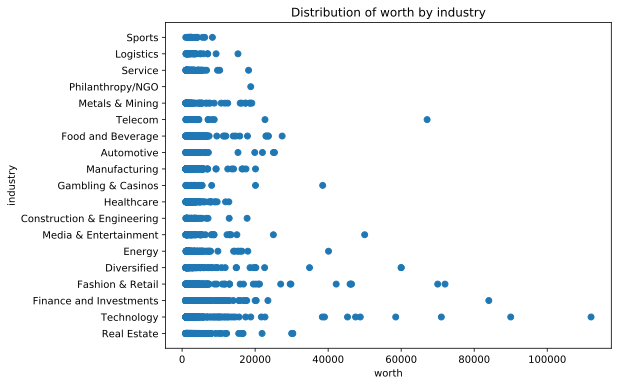

In [11]:
plt.figure(figsize=(8, 6))

plt.scatter(df['worth'], df['industry'])

plt.xlabel('worth')
plt.ylabel('industry')
plt.title('Distribution of worth by industry')
plt.show()

### Распределение капитала по возрасту

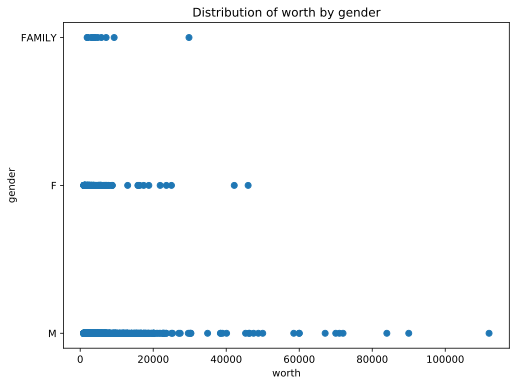

In [30]:
plt.figure(figsize=(8, 6))

plt.scatter(df['worth'], df['gender'])

plt.xlabel('worth')
plt.ylabel('gender')
plt.title('Distribution of worth by gender')
plt.show()

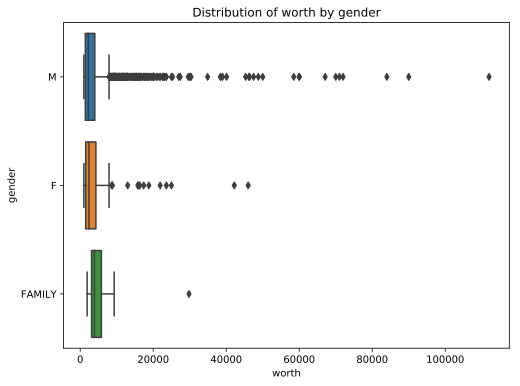

In [13]:
plt.figure(figsize=(8, 6))

sns.boxplot(df['worth'], df['gender'])

plt.xlabel('worth')
plt.ylabel('gender')
plt.title('Distribution of worth by gender')
plt.show()

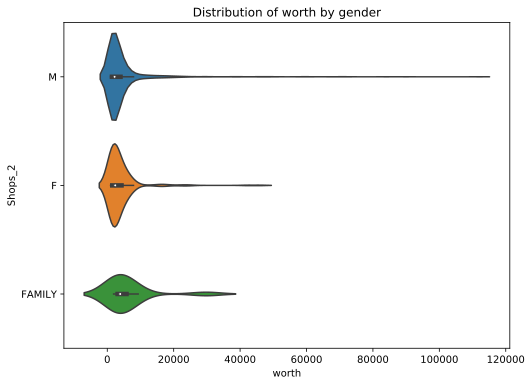

In [14]:
plt.figure(figsize=(8, 6))

sns.violinplot(df['worth'], df['gender'])

plt.xlabel('worth')
plt.ylabel('Shops_2')
plt.title('Distribution of worth by gender')
plt.show()

### Описание данных

In [16]:
df.describe()

,position,age,worth,worthChange,realTimeWorth,realTimePosition
count,2208.000000,2190.000000,2208.000000,2153.000000,0.0,2260.000000
mean,1104.500000,63.858904,4103.079710,-0.473434,NaN,1112.961062
std,637.539018,13.126983,6913.083904,26.010403,NaN,633.961674
min,1.000000,21.000000,1000.000000,-672.311000,NaN,1.000000
25%,552.750000,54.000000,1400.000000,0.000000,NaN,562.750000
50%,1104.500000,64.000000,2200.000000,0.000000,NaN,1123.500000
75%,1656.250000,73.000000,4000.000000,0.000000,NaN,1676.250000
max,2208.000000,99.000000,112000.000000,530.206000,NaN,2153.000000


In [17]:
df.describe(include=[object])

,name,lastName,country,gender,wealthSource,industry,image
count,2260,2260,2260,2260,2260,2260,2260
unique,2258,1581,72,3,798,19,1836
top,Jim Davis,Wang,United States,M,real estate,Finance and Investments,https://specials-images.forbesimg.com/imageser...
freq,2,34,596,1997,181,315,8


### Среднее и медиана по возрасту почти сопдадают

In [20]:
age_mean = round(df['age'].mean(), 2)
age_median = df['age'].median()

age_mean, age_median

(63.86, 64.0)

### Распределение по возрасту похоже на нормальное

D:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


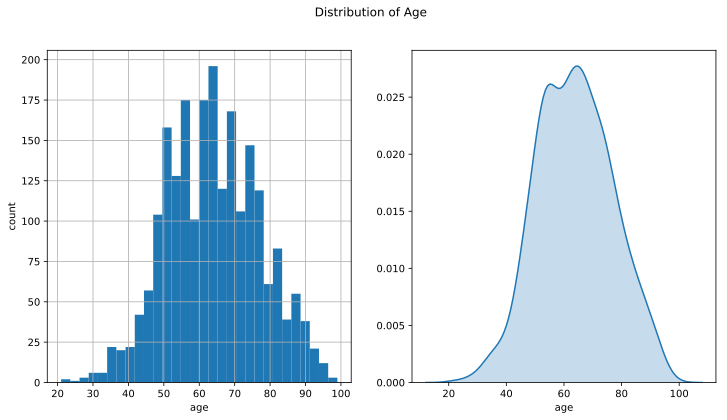

In [33]:
matplotlib.rcParams.update({'font.size': 10})
plt.style.use('default')
plt.figure(figsize = (12, 6))

plt.subplot(121)
df['age'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('age')

plt.subplot(122)
sns.kdeplot(df['age'], shade=True, legend=False)
plt.xlabel('age')

plt.suptitle('Distribution of Age')
plt.show()

### Распределение по капиталу

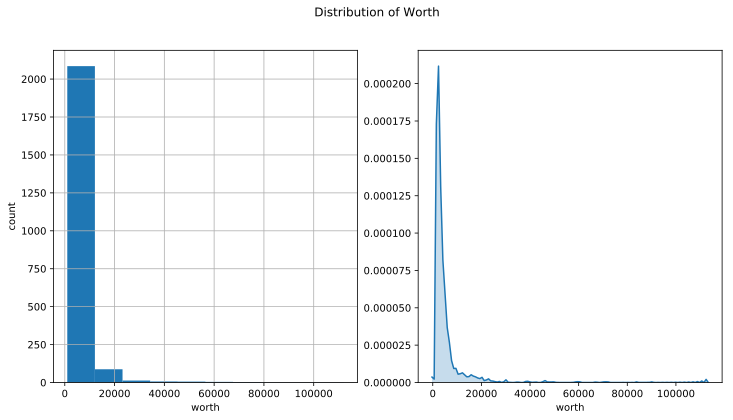

In [19]:
plt.figure(figsize = (12, 6))

plt.subplot(121)
df['worth'].hist()
plt.ylabel('count')
plt.xlabel('worth')

plt.subplot(122)
sns.kdeplot(df['worth'], shade=True, legend=False)
plt.xlabel('worth')

plt.suptitle('Distribution of Worth')
plt.show()

### QQ-график для возраста

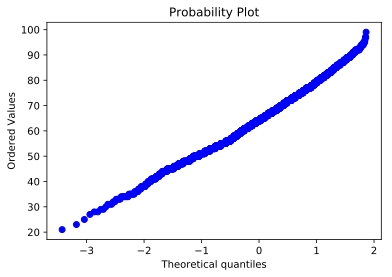

In [28]:
np_age = df['age'].to_numpy()
stats.probplot(np_age, dist="norm", plot=pylab)
pylab.show()

### QQ-график для капитала

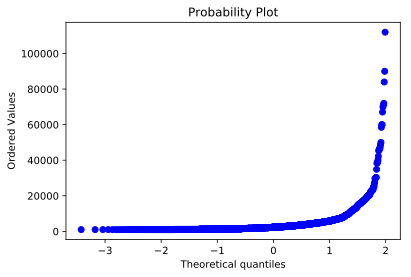

In [32]:
np_age = df['worth'].to_numpy()
stats.probplot(np_age, dist="norm", plot=pylab)
pylab.show()

In [37]:
df.dtypes

position            float64
name                 object
lastName             object
age                 float64
country              object
gender               object
wealthSource         object
industry             object
worth               float64
worthChange         float64
realTimeWorth       float64
realTimePosition      int64
image                object
dtype: object